## SAR-Ship Dataset for very deep learning
Data [here:](https://gitlab.com/sarmaps/sar-ship-dataset)

Article [here:](https://sci-hub.ren/10.1109/igarss.2016.7729017)

In [2]:
import os

import numpy as np 
import pandas as pd 
from collections import Counter
from os.path import join
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab
import cv2
%matplotlib inline

import sys
sys.path.append('/home/mkhudinyan/GitHub/sar_ship_detect/scripts')
from utils import simple_data_split, data_extractor, im_resize

In [3]:
# Define path to the data
PATH = '/home/mkhudinyan/GitHub/sar_ship_detect/'
# data_path = join(os. getcwd(), '..','data', 'very_deep_learn_data', 'json')
data_path = join(PATH, 'data', 'very_deep_learn_data', 'json')

In [4]:
os.listdir(data_path)

['true_negatives.json', 'false_positives.json', 'ship_positives.json']

### DATA DESCRIPTION
A SAR dataset has been created using 22 Sentinel-1 (Extra
Wide Swath) and 3 RADARSAT-2 (Scan-SAR Narrow) acquisition with a total of 42 dual and 4 single polarized, radiometrically calibrated images. The dataset covers approximately 80% of the South African Exclusive Economic Zone (EEZ) with multiple acquisitions over a number of harbours (high ship densities). For this experiment, the dataset was analysed and split into three classes of `21 × 21` sub-images, containing **ships** (`positives`), **ship-like areas** (`false positives`) and **ocean areas** (`negatives`). The usefulness of splitting the samples up into three classes is that it now allows for a more descriptive analysis of how various methods deal with `ship lookalikes` and open ocean areas. The `1596 positive examples` were identified using expert analysis with each ship having an associated ground truth image not used in this experiment. The false positive sub-images were generated by selecting areas that did not contain ships but were incorrectly highlighted by a `low-threshold cell-averaging constant false alarm rate` (CA-CFAR). This lowthreshold approach was done to generate as many samples as possible for future experiments. Of the approximate 500 000 false positive sub-images extracted across the 46 images, `3192 false positive` images were selected at random. This is twice as many as the positive examples and represents the distribution of false positives to positives that would be encountered with careful prescreening threshold design and selection. Finally, `1596 sub-images that did not contain either a ship or false positive` were selected as negative ocean samples. Depending on the selected prescreening method, the negative samples will often not be presented to the ship discrimination classifier. They are provided here, however, to train the classifier to handle negative samples. No additional feature extraction was performed on the 9588 sub-images resulting in input feature set of 21x21 normalized RCS pixel values per image․

In [5]:
#Load the data.
false_positives = pd.read_json(join(data_path, 'false_positives.json'))
ship_positives = pd.read_json(join(data_path, 'ship_positives.json'))
true_negatives = pd.read_json(join(data_path, 'true_negatives.json'))

In [6]:
print('true_positives: ',ship_positives.shape)
print('false_positives:',false_positives.shape) # not corresponding to the data describtion, should be checked out
print('true_negatives: ',true_negatives.shape)

true_positives:  (1, 1596)
false_positives: (1, 6384)
true_negatives:  (1, 1596)


#### Downsample the false positive class in order to balance tha dataset

In [7]:
false_positives= false_positives.iloc[:, 0: ship_positives.shape[1]]
print('false_positives:',false_positives.shape)

false_positives: (1, 1596)


## Data Pre-processing

**extract** the neccessary data from the datasets and **Resize** the images.

`dsize` defines the ultimate image chip size for training CNN model

##### Recover the incidence angle as a band

In [8]:
dsize = (75, 75)

# get true positive data
ship_positive_data = data_extractor(ship_positives, 'windowfu')
#ship_positive_target = data_extract(ship_positives, 'validais')
ship_positive_angle = data_extractor(ship_positives,  'incidenceangle', ship_positive_data.shape[-1])
# define ship target class as "2"
ship_positive_target = np.full(ship_positives.shape[1], 2)

# Resize the images
ship_positive_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in ship_positive_data])
ship_positive_angle_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in ship_positive_angle])

In [9]:
# get false positive data
false_positives_data = data_extractor(false_positives, 'windowfu')
false_positives_angle = data_extractor(false_positives, 'incidenceangle', false_positives_data.shape[-1])
false_positives_target = data_extractor(false_positives, 'thresh')

# Resize the images
false_positives_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in false_positives_data])
false_positives_angle_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in false_positives_angle])

In [10]:
# get true negative data
true_negatives_data = data_extractor(true_negatives, 'windowfu')
true_negatives_angle = data_extractor(true_negatives, 'incidenceangle', true_negatives_data.shape[-1])
true_negatives_target = data_extractor(true_negatives, 'thresh')

# Resize the images
true_negatives_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in true_negatives_data])
true_negatives_angle_75 = np.array([im_resize(image, dsize, cv2.INTER_CUBIC) for image in true_negatives_angle])

### Data visualization

#### Original (21x21)

Text(0.5, 1.0, 'random noise')

<Figure size 432x288 with 0 Axes>

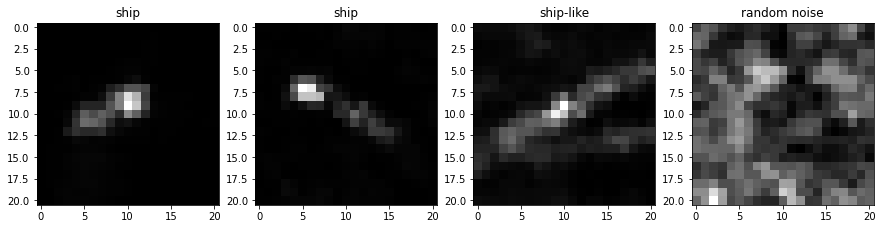

In [11]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ship_positive_data[1200,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_data[14,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(false_positives_data[43,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(true_negatives_data[121,:,:], cmap="gray") 
axarr[3].set_title('random noise')

#### Resized (75x75)

Text(0.5, 1.0, 'random noise')

<Figure size 432x288 with 0 Axes>

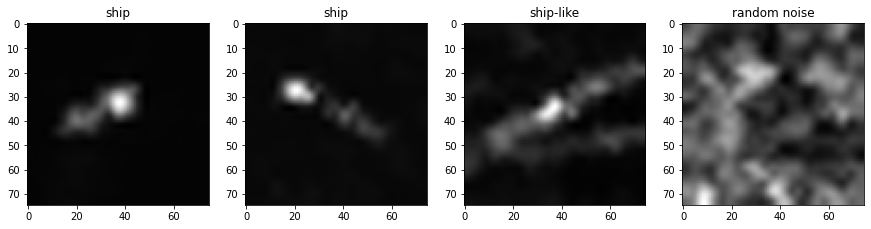

In [12]:
# visualize image samples 

plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(ship_positive_75[1200,:,:], cmap="gray")
axarr[0].set_title('ship')
axarr[1].imshow(ship_positive_75[14,:,:], cmap="gray")  
axarr[1].set_title('ship')
axarr[2].imshow(false_positives_75[43,:,:], cmap="gray")
axarr[2].set_title('ship-like')
axarr[3].imshow(true_negatives_75[121,:,:], cmap="gray") 
axarr[3].set_title('random noise')

In [13]:
# combining all the classes into one nd array
radar_data = np.concatenate([ship_positive_75, false_positives_75, true_negatives_75])
angle_data = np.concatenate([ship_positive_angle_75, false_positives_angle_75, true_negatives_angle_75])
target = np.concatenate([ship_positive_target, false_positives_target, true_negatives_target])

In [14]:
# combining 2 band into one stack
data = np.concatenate([radar_data[:, :, :, np.newaxis], angle_data[:, :, :, np.newaxis]], axis=-1)

In [15]:
# class' destibution
# 0 - true negative
# 1 - true positive
# 2 - false positive
class_label = {
    0: 'random noise',
    1: 'ship-like',
    2: 'ship'
}

# give class labes to the target values
labeled_target = np.vectorize(class_label.get)(target)

pd.DataFrame([dict(Counter(labeled_target))])

,ship,ship-like,random noise
0,1596,1596,1596


## Building the Model

In [16]:
#Import Keras.
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
# from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.metrics import binary_accuracy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#import tensorflow_adons as tfa

2022-02-15 11:28:43.141746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mkhudinyan/anaconda3/envs/ship/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-15 11:28:43.141767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Model architecture modification

CNN model is modified the way to handle with 3 classes using 2 input bands: nrcs and inc. angle

In [35]:
# adaptation to 2 band input shape
#define our model
def getModel():
    #Building the model
    gmodel=Sequential()
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 2))) 
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    #gmodel.add(Dense(1))
    #gmodel.add(Activation('sigmoid'))
    
    #Output Layer
    gmodel.add(Dense(3))                                # set 3 classes for the last output layer
    gmodel.add(Activation('softmax'))                   # 'softmax' as activ. func. for multiclass classif
    
    # compile model
    #mypotim = SGD(lr=0.01, momentum=0.9)
    mypotim=tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='sparse_categorical_crossentropy',  
                  optimizer=mypotim,
                  metrics=['accuracy'])                     # f1_score to be implemented (also ROC-AUC)
    gmodel.summary()
    return gmodel


def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]

#file_path = ".model_weights.hdf5"
#file_path = ".model_weights_very_deep_learn_balanced_ds.hdf5"
weigth_path = join(PATH, 'model_weights', '.model_weights_very_deep_learn_balanced_ds.hdf5')
callbacks = get_callbacks(filepath=weigth_path, patience=10) # increased the "patience"

### Data split

In [17]:
# define split parameters
train_size = 0.75
valid_size = 0.20 # partition of only training data

X_train_cv, X_valid, X_test, y_train_cv, y_valid, y_test = simple_data_split(
                                        data, target, train_size, valid_size )
print(f'data split: \nTrain: \t    {X_train_cv.shape[0]} \
        \nValidation: {X_valid.shape[0]} \nTest: \t    {X_test.shape[0]}')

data split: 
Train: 	    2872         
Validation: 719 
Test: 	    1197


In [37]:
#Without denoising, core features.
gmodel=getModel()
gmodel.fit(X_train_cv, y_train_cv,
          batch_size=24,
          epochs=50,
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 64)        1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

2022-02-14 13:30:08.878158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-14 13:30:08.878979: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mkhudinyan/anaconda3/envs/ship/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-14 13:30:08.879222: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/mkhudinyan/anaconda3/envs/ship/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-14 13:30:08.879372: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library '

Epoch 1/50
120/120 [==============================] - 12s 99ms/step - loss: 1.2310 - accuracy: 0.3437 - val_loss: 1.0671 - val_accuracy: 0.4033
Epoch 2/50
120/120 [==============================] - 12s 101ms/step - loss: 1.0602 - accuracy: 0.4241 - val_loss: 0.9880 - val_accuracy: 0.5174
Epoch 3/50
120/120 [==============================] - 12s 103ms/step - loss: 0.8691 - accuracy: 0.6243 - val_loss: 0.9239 - val_accuracy: 0.5508
Epoch 4/50
120/120 [==============================] - 12s 101ms/step - loss: 0.6999 - accuracy: 0.7253 - val_loss: 0.4686 - val_accuracy: 0.8540
Epoch 5/50
120/120 [==============================] - 12s 103ms/step - loss: 0.7274 - accuracy: 0.6981 - val_loss: 0.6361 - val_accuracy: 0.7566
Epoch 6/50
120/120 [==============================] - 13s 112ms/step - loss: 0.5987 - accuracy: 0.7719 - val_loss: 0.6181 - val_accuracy: 0.7330
Epoch 7/50
120/120 [==============================] - 13s 105ms/step - loss: 0.5838 - accuracy: 0.7639 - val_loss: 0.4146 - val_acc

In [38]:
# model validation evaluation
gmodel.load_weights(weigth_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

23/23 [==============================] - 1s 26ms/step - loss: 0.2605 - accuracy: 0.9082
Test loss: 0.2604694366455078
Test accuracy: 0.9082058668136597


In [39]:
# model test evaluation
score = gmodel.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

38/38 [==============================] - 1s 27ms/step - loss: 0.2291 - accuracy: 0.9231
Test loss: 0.22906489670276642
Test accuracy: 0.9231411814689636


### Calculate more metrics

##### Classification results and discussion 

As it was expected from the explanatory analysis, the images having random noise (negative class) are described by a random distribution of radar backscattering aver all the image's scene and were significantly different from the ships and ship-likes, thus, this class was the easiest for the model to classify (recall value eq. 0.98). Contrary to that, ship-likes backscattering resembles a lot the ships. The result shows that ship class was mainly misclassifieds as ship-likes as was expected (see the confusion matrix), but still having a very high **True Positive Rate** (same as recall): **0.95**. From the confusion matrix we can observe also that the ship-like class has the highest misclassification rate and is being classified as ship, causing for relatively high **False Positive Rate: 0.12** (`FP/(FP+TN)`). **Overall Classification Accuracy is 0.92**.

In [40]:
# Classification report
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
labels = np.array(['random noise 0', 'ship-like 1', 'ship 2'])

print()
print(classification_report(y_test, y_pred_bool, target_names=labels))
print('Confusion matrix \n', confusion_matrix(y_test, y_pred_bool))

19/19 [==============================] - 1s 57ms/step

                precision    recall  f1-score   support

random noise 0       0.94      0.99      0.96       399
   ship-like 1       0.95      0.84      0.89       399
        ship 2       0.89      0.94      0.91       399

      accuracy                           0.92      1197
     macro avg       0.92      0.92      0.92      1197
  weighted avg       0.92      0.92      0.92      1197

Confusion matrix 
 [[394   5   0]
 [ 16 337  46]
 [ 11  14 374]]


In [ ]:
# Classification report
y_pred = gmodel.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
labels = np.array(['random noise 0', 'ship-like 1', 'ship 2'])

print()
print(classification_report(y_test, y_pred_bool, target_names=labels))
print('Confusion matrix \n', confusion_matrix(y_test, y_pred_bool))

1197/1197 [==============================] - 9s 7ms/step

                precision    recall  f1-score   support

random noise 0       0.95      0.98      0.97       399
   ship-like 1       0.94      0.83      0.88       399
        ship 2       0.88      0.95      0.91       399

      accuracy                           0.92      1197
     macro avg       0.92      0.92      0.92      1197
  weighted avg       0.92      0.92      0.92      1197

Confusion matrix 
 [[392   5   2]
 [ 14 333  52]
 [  5  16 378]]


In [41]:
# get the indexes of the images being wrongly classified
#incorrects = np.argwhere(y_pred_bool != y_test)
incorrects = np.nonzero(y_pred_bool != y_test)[0]
incorrects

array([   3,    9,   43,   53,   54,   82,   88,  104,  113,  115,  125,
        132,  148,  183,  185,  209,  226,  250,  261,  270,  276,  281,
        301,  349,  354,  355,  359,  367,  386,  395,  431,  439,  458,
        465,  472,  496,  516,  528,  535,  546,  554,  576,  585,  587,
        588,  590,  607,  616,  640,  699,  702,  703,  718,  727,  731,
        740,  743,  753,  758,  778,  779,  810,  826,  838,  841,  847,
        850,  851,  886,  905,  908,  932,  939,  971,  974,  996, 1000,
       1021, 1026, 1029, 1070, 1087, 1097, 1099, 1103, 1111, 1123, 1127,
       1132, 1162, 1170, 1174])

### Visualize misclassified image examples

In [122]:
y_test[183], y_pred_bool[183]

(0, 1)

... actual images being misclassified as...


Text(0.5, 1.0, 'ship as noise')

<Figure size 432x288 with 0 Axes>

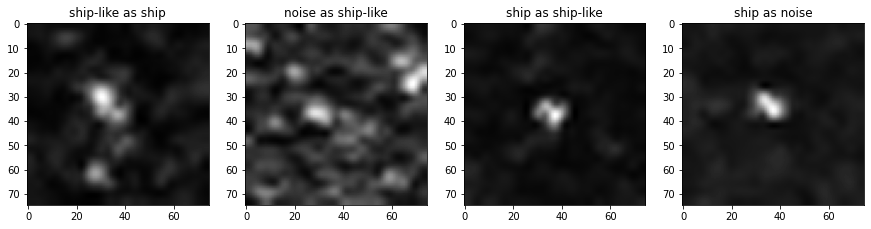

In [42]:
# visualize image samples 
print("... actual images being misclassified as...")
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,4, figsize=(15, 15)) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(X_test[3,:,:,0], cmap="gray")
axarr[0].set_title('ship-like as ship')
axarr[1].imshow(X_test[183,:,:,0], cmap="gray")  
axarr[1].set_title('noise as ship-like')
axarr[2].imshow(X_test[386,:,:,0], cmap="gray")
axarr[2].set_title('ship as ship-like')
axarr[3].imshow(X_test[616,:,:,0], cmap="gray") 
axarr[3].set_title('ship as noise')